In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from datetime import timedelta, date
from py_scripts.plotting import CustomJointGrid
from scipy.stats import norm
from scipy.interpolate import interp1d

# SnowFall Problem
## Clean the data

In [2]:
# import the data 2239075.csv and clean it, especifically we want to group by year and
# sum the snowfall
df_raw = pd.read_csv('2239075.csv', parse_dates=[2])

df = pd.DataFrame({
    "x": df_raw.DATE.dt.year,
    "y": df_raw.SNOW,
}).groupby("x").y.sum()
df = df.iloc[1:-1]

offset = df.index.values.mean().round()
df.index -= offset

## Come up with a estimate for the hypothesis space
Finally I used the values in the notebook, but for future problems this could be a good step to have a feeling about where the hypotheses live.

In [3]:
model = 'y ~ x'
estimate = smf.ols(model, df.reset_index()).fit()
x0, m = estimate.params  # x0=62.56; m=.42
residual = estimate.resid

## Build the hypothesis space df

In [4]:
hs_x0 = np.linspace(54, 75, 41)
hs_m = np.linspace(-.5, 1.5, 51)
hs_sigma = np.linspace(20, 35, 31)

meshes = np.meshgrid(hs_m, hs_x0, hs_sigma)
cols = ["m", "x0", "sigma"]
likes = pd.DataFrame({col: mesh.ravel() for col, mesh in zip(cols, meshes)})

## Compute the likes

In [5]:
# Create the appropriate meshes to deal with the calculation below
x_mesh, x0_mesh = np.meshgrid(df.index.values, likes.x0)
y_mesh, m_mesh = np.meshgrid(df.values, likes.m)
_, sigma_mesh = np.meshgrid(df.values, likes.sigma)

# Use the linear model on a normal distribution to come up with the likelihood
expected = (x0_mesh + m_mesh * x_mesh)
observations = y_mesh - expected
likes["likes"] = norm(0, sigma_mesh).pdf(observations).prod(axis=1)

# Run the update
likes["posterior"] = likes.likes / likes.likes.sum()

## Plot outcomes

Marginal x0 stats:
The expected value is: 64.44820250931714
The MAP is: 64.5
The CI is: [58.725, 70.275]
*************************
Marginal m stats:
The expected value is: 0.5118702152608382
The MAP is: 0.5
The CI is: [0.09999999999999998, 0.9000000000000001]


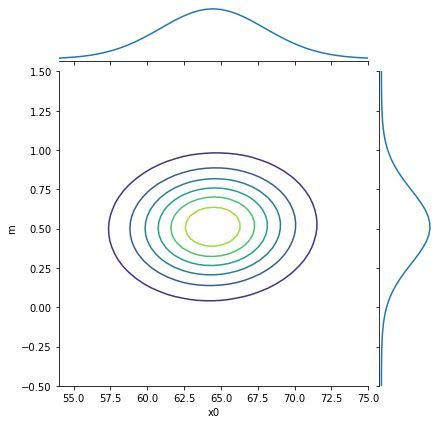

In [6]:
joint_dataframe = likes.pivot_table(index='m', columns="x0", values="likes")
CustomJointGrid(joint_dataframe).run()

# Marathon World Record

## Grab the data

In [7]:
url = 'https://en.wikipedia.org/wiki/Marathon_world_record_progression#Men'
tables = pd.read_html(url)

## Clean the data

In [8]:
df_raw = tables[0]
df_raw["date"] = pd.to_datetime(df_raw.Date, errors="coerce")
df_raw["time"] = pd.to_timedelta(df_raw.Time)
df_raw["y"] = 26.2 / df_raw.time.dt.total_seconds() * 3600
df = df_raw[["date", "y"]].copy()

# Plot the speed timeseries
# fig, ax = plt.subplots()
# ax.scatter(x=df.date, y=df.y, color='C1', alpha=.5);

# Filter 1970 onwards
df1 = df[df.date > '1970-01-01'].copy()

# plot a lmplot
df1["year"] = df1.date.dt.year
# sns.lmplot(x="year", y="y", data=df1)

# Offset the dates
timespan = df1.date.max() - df1.date.min()  # 52 years
mid_date = date(df1.date.dt.year.max() - int(timespan.days / (2*365)), 1, 1)
df1["x"] = (df1.date - pd.to_datetime(mid_date)).dt.days / 365

## Come up with an estimate for the hypothesis space

In [9]:
formula = 'y ~ x'
results = smf.ols(formula, data=df1).fit()
x0, m = results.params  # x0=12.479, m=0.0159
s = results.resid.std()  # 0.0441

## Create hypothesis spaces

In [10]:
hs_m = np.linspace(.012, .02, 51)
hs_x0 = np.linspace(12.44, 12.52, 41)
hs_sigma = np.linspace(.01, .1, 31)

# Create the df for computations
meshes = np.meshgrid(hs_m, hs_x0, hs_sigma)
cols = ["m", "x0", "sigma"]
bt = pd.DataFrame({col: mesh.ravel() for col, mesh in zip(cols, meshes)})

## Compute likes

In [11]:
x_mesh, x0_mesh = np.meshgrid(df1.x, bt.x0)
y_mesh, m_mesh = np.meshgrid(df1.y, bt.m)
_, sigma_mesh = np.meshgrid(df1.y, bt.sigma)
expected = x0_mesh + m_mesh * x_mesh
observations = y_mesh - expected
bt["likes"] = norm(0, sigma_mesh).pdf(observations).prod(axis=1)
bt["posterior"] = bt.likes / bt.likes.sum()

## Plot the outcomes

Marginal x0 stats:
The expected value is: 12.479960548978665
The MAP is: 12.48
The CI is: [12.462, 12.498]
*************************
Marginal m stats:
The expected value is: 0.01592025188992799
The MAP is: 0.016
The CI is: [0.01472, 0.01712]


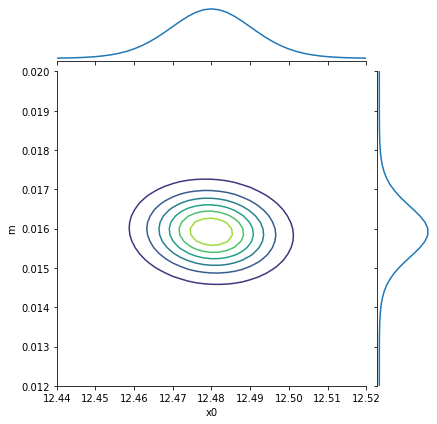

In [12]:
marginal_sigma = bt.pivot_table(index="x0", columns="sigma", values="posterior", aggfunc='sum')
# marginal_sigma.sum().plot();

# Update and plot JointGrid
joint = bt.pivot_table(index="m", columns="x0", values="posterior", aggfunc="sum")
g = CustomJointGrid(joint)
g.run()

## Predict

[array(2039.03615891), array(2033.54467267), array(2028.4366091)]

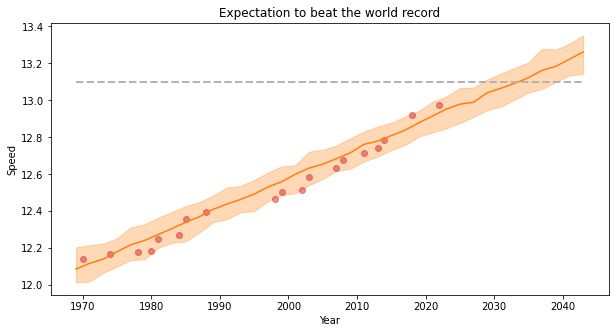

In [15]:
# Sample from the distribution to do a prediction and get the 5, 50 and 95 percentiles
# We have an array of 64821 rows, let's sample a 100 of them with the weights given by the
# posterior
np.random.seed(500)
sample = bt.sample(100, weights=bt.posterior)

# Create the range we will use for predictions
xs = np.arange(-25, 50, 2)  # 38
assert xs.size == 38

# Create some meshes to compute predictions for each sample value and each xs
x_mesh, m_mesh = np.meshgrid(xs, sample.m)
_, x0_mesh = np.meshgrid(xs, sample.x0)
_, sigma_mesh = np.meshgrid(xs, sample.sigma)

# Compute the prediction using the linear model
prediction = x0_mesh + m_mesh * x_mesh + norm(0, sigma_mesh).rvs()
assert prediction.shape == (100, 38)

# Finally compute the three percentiles over the samples (axis=0) for each column (xs)
low, mid, hi = np.percentile(prediction, [5, 50, 95], axis=0)

# Plot the results
_, ax = plt.subplots(figsize=(10, 5))

years = xs + offset  # Add the offset back in.
ax.plot(years, mid, color="C1")
ax.fill_between(years, low, hi, color="C1", alpha=.3)
ax.scatter(x=df1.date.dt.year, y=df1.y, color='C3', alpha=.5);  # Original data

# Plot the limit
two_hour_mark = np.full(xs.size, 26.2 / 2,)
ax.plot(years, two_hour_mark, color="0.7", ls="--", lw=2);

# Decorate
ax.set_title("Expectation to beat the world record")
ax.set_xlabel("Year")
ax.set_ylabel("Speed")

[interp1d(chances, years)(13.1) for chances in (low, mid, hi)]